In [27]:
# imports
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from pathlib import Path

# keep pandas quiet about chained assignments in recent versions
try:
    pd.set_option("mode.copy_on_write", True)
except Exception:
    pass

import matplotlib.pyplot as plt
# Ensure inline rendering in Jupyter (safe no-op outside)
try:
    get_ipython().run_line_magic('matplotlib', 'inline')
except Exception:
    pass

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve
)
import joblib


In [28]:
# Paths
def resolve_base_dir() -> Path:
    candidates = [
        Path.cwd() / "data",  # ./data next to notebook
        Path(r"C:\Probook\E\AI\Projects\Data Science\Predictive Maintenance\PdM.csv"),
        Path("/mnt/data"),
    ]
    for p in candidates:
        if p.exists():
            return p
    raise FileNotFoundError("Data folder not found. Create ./data or update candidates in resolve_base_dir().")

BASE_DIR = resolve_base_dir()
print("[INFO] BASE_DIR =", BASE_DIR)

telemetry_path = BASE_DIR / "PdM_telemetry_small40.csv"
failures_path  = BASE_DIR / "PdM_failures.csv"
machines_path  = BASE_DIR / "PdM_machines.csv"

assert telemetry_path.exists(), f"Missing {telemetry_path}"
assert failures_path.exists(),  f"Missing {failures_path}"
assert machines_path.exists(),  f"Missing {machines_path}"


[INFO] BASE_DIR = C:\Probook\E\AI\Projects\Data Science\Predictive Maintenance\PdM.csv


In [29]:
# Load & Clean
tele = pd.read_csv(telemetry_path)
fails = pd.read_csv(failures_path)
machines = pd.read_csv(machines_path)

tele["datetime"]  = pd.to_datetime(tele["datetime"], errors="coerce")
fails["datetime"] = pd.to_datetime(fails["datetime"], errors="coerce")

tele  = tele.sort_values(["machineID","datetime"]).drop_duplicates(["machineID","datetime"]).reset_index(drop=True)
fails = fails.sort_values(["machineID","datetime"]).drop_duplicates(["machineID","datetime"]).reset_index(drop=True)

for df in (tele, fails, machines):
    if "machineID" in df.columns:
        df["machineID"] = df["machineID"].astype(int)

print(f"[INFO] telemetry: {tele.shape} | failures: {fails.shape} | machines: {machines.shape}")
tele.head(3)


[INFO] telemetry: (350440, 6) | failures: (719, 3) | machines: (100, 3)


,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847


In [30]:
# 24h Labeling
def make_labels_24h(tele_df: pd.DataFrame, fails_df: pd.DataFrame, horizon_h: float = 24.0) -> pd.DataFrame:
    parts = []
    for mid, g in tele_df.groupby("machineID", sort=True):
        g = g.sort_values("datetime").copy()
        f = (fails_df.loc[fails_df["machineID"] == mid, ["datetime"]]
                      .rename(columns={"datetime":"fail_time"})
                      .sort_values("fail_time"))
        if f.empty:
            g["label_next24h"] = 0
            parts.append(g)
            continue

        g = pd.merge_asof(g, f, left_on="datetime", right_on="fail_time", direction="forward")
        dt_h = (g["fail_time"] - g["datetime"]).dt.total_seconds() / 3600.0
        g["label_next24h"] = ((dt_h > 0) & (dt_h <= horizon_h)).astype(int)
        g.drop(columns=["fail_time"], inplace=True)
        parts.append(g)

    labeled = (pd.concat(parts, axis=0)
                 .sort_values(["machineID","datetime"])
                 .reset_index(drop=True))
    share = labeled["label_next24h"].value_counts(normalize=True).mul(100).round(2)
    print("[INFO] label distribution (%) →", dict(share))
    return labeled

tele_labeled = make_labels_24h(tele, fails)
tele_labeled.head(3)


[INFO] label distribution (%) → {0: 98.08, 1: 1.92}


,datetime,machineID,volt,rotate,pressure,vibration,label_next24h
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,0
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,0
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,0


Records per machine (head):
machineID
1    8761
2    8761
3    8761
4    8761
5    8761
Name: count, dtype: int64


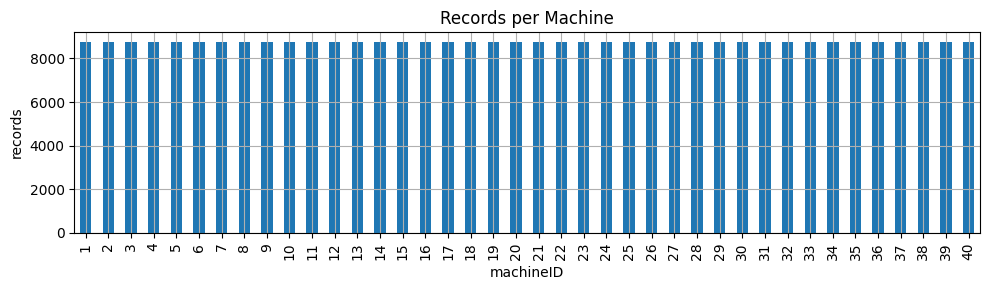


Failures per machine (head):
machineID
1    168
2     72
3    120
4    144
5    168
Name: label_next24h, dtype: int64


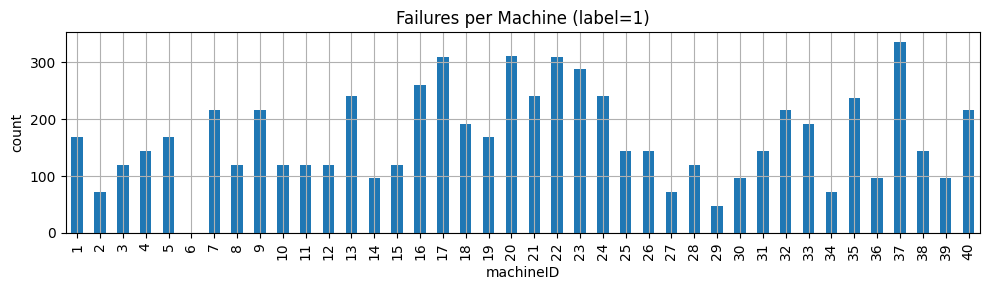


Label distribution (%)
label_next24h
0    98.08
1     1.92
Name: proportion, dtype: float64


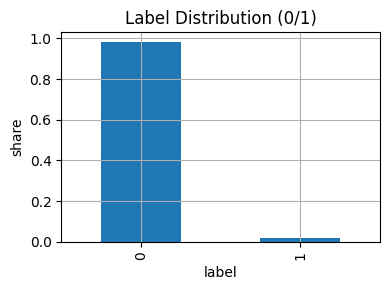

In [31]:
# EDA
def quick_eda(df: pd.DataFrame) -> None:
    rec_per_machine = df["machineID"].value_counts().sort_index()
    print("Records per machine (head):")
    print(rec_per_machine.head())
    plt.figure(figsize=(10,3))
    rec_per_machine.plot.bar(grid=True)
    plt.title("Records per Machine")
    plt.xlabel("machineID"); plt.ylabel("records")
    plt.tight_layout(); plt.show()

    fails_pm = df.groupby("machineID")["label_next24h"].sum().sort_index()
    print("\nFailures per machine (head):")
    print(fails_pm.head())
    plt.figure(figsize=(10,3))
    fails_pm.plot.bar(grid=True)
    plt.title("Failures per Machine (label=1)")
    plt.xlabel("machineID"); plt.ylabel("count")
    plt.tight_layout(); plt.show()

    lbl = df["label_next24h"].value_counts(normalize=True).mul(100).round(2)
    print("\nLabel distribution (%)")
    print(lbl)
    plt.figure(figsize=(4,3))
    df["label_next24h"].value_counts(normalize=True).plot.bar(grid=True)
    plt.title("Label Distribution (0/1)")
    plt.xlabel("label"); plt.ylabel("share")
    plt.tight_layout(); plt.show()

quick_eda(tele_labeled)


In [32]:
# Rolling Features (3H, 6H)
ROLL_SENSORS = ["volt", "rotate", "pressure", "vibration"]
ROLL_WINDOWS = ["3H", "6H"]

def add_rolling_features(df: pd.DataFrame) -> pd.DataFrame:
    out = []
    for mid, g in df.groupby("machineID", sort=True):
        g = g.sort_values("datetime").copy().set_index("datetime")
        for s in ROLL_SENSORS:
            if s not in g.columns:
                continue
            for win in ROLL_WINDOWS:
                g[f"{s}_mean_{win}"] = g[s].rolling(win, min_periods=2).mean()
                g[f"{s}_std_{win}"]  = g[s].rolling(win, min_periods=2).std()
        out.append(g.reset_index())
    feats = (pd.concat(out, axis=0)
               .sort_values(["machineID","datetime"])
               .reset_index(drop=True))
    print("[INFO] features with rolling →", feats.shape)
    return feats

tele_feats = add_rolling_features(tele_labeled)
tele_feats.filter(regex="(volt|rotate|pressure|vibration)_(mean|std)").head(3)


[INFO] features with rolling → (350440, 23)


,volt_mean_3H,volt_std_3H,volt_mean_6H,volt_std_6H,rotate_mean_3H,rotate_std_3H,rotate_mean_6H,rotate_std_6H,pressure_mean_3H,pressure_std_3H,pressure_mean_6H,pressure_std_6H,vibration_mean_3H,vibration_std_3H,vibration_mean_6H,vibration_std_6H
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,169.548538,9.431836,169.548538,9.431836,410.625784,11.141591,410.625784,11.141591,104.269230,12.457390,104.269230,12.457390,44.250829,1.183494,44.250829,1.183494
2,170.028993,6.721032,170.028993,6.721032,449.533798,67.849599,449.533798,67.849599,94.592122,18.934956,94.592122,18.934956,40.893502,5.874970,40.893502,5.874970


In [33]:
# Join Machine Meta, Clean, and Build X/y (+Scaled)
df = tele_feats.merge(machines[["machineID","age","model"]], on="machineID", how="left")

y = df["label_next24h"].astype(int)
X = df.drop(columns=["datetime","label_next24h"]).copy()

# one-hot for categorical fields (e.g., model)
non_num = X.select_dtypes(include=["object","category"]).columns.tolist()
if non_num:
    X = pd.get_dummies(X, columns=non_num, drop_first=True)

# drop NA introduced by rolling
na_mask = X.isna().any(axis=1)
if na_mask.any():
    X = X.loc[~na_mask].reset_index(drop=True)
    y = y.loc[~na_mask].reset_index(drop=True)

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X.values), columns=X.columns)

print(f"[INFO] X_raw: {X.shape} | X_scaled: {X_scaled.shape} | y: {y.shape}")
X.head(3)


[INFO] X_raw: (350400, 25) | X_scaled: (350400, 25) | y: (350400,)


,machineID,volt,rotate,pressure,vibration,volt_mean_3H,volt_std_3H,volt_mean_6H,volt_std_6H,rotate_mean_3H,...,pressure_mean_6H,pressure_std_6H,vibration_mean_3H,vibration_std_3H,vibration_mean_6H,vibration_std_6H,age,model_model2,model_model3,model_model4
0,1,162.879223,402.747490,95.460525,43.413973,169.548538,9.431836,169.548538,9.431836,410.625784,...,104.269230,12.457390,44.250829,1.183494,44.250829,1.183494,18,False,True,False
1,1,170.989902,527.349825,75.237905,34.178847,170.028993,6.721032,170.028993,6.721032,449.533798,...,94.592122,18.934956,40.893502,5.874970,40.893502,5.874970,18,False,True,False
2,1,162.462833,346.149335,109.248561,41.122144,165.443986,4.807415,168.137453,6.665324,425.415550,...,98.256232,17.109194,39.571655,4.808836,40.950662,4.798255,18,False,True,False


In [34]:
# Train/Test + Random Forest
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

rf = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced_subsample",
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train, y_train)

y_proba = rf.predict_proba(X_test)[:, 1]
y_pred  = (y_proba >= 0.50).astype(int)

# quick peek at top importances
imp = pd.DataFrame({"feature": X_train.columns, "importance": rf.feature_importances_}) \
        .sort_values("importance", ascending=False) \
        .reset_index(drop=True)
imp.head(10)


,feature,importance
0,rotate_mean_6H,0.155466
1,volt_mean_6H,0.135266
2,vibration_mean_6H,0.117920
3,rotate_mean_3H,0.076354
4,pressure_mean_6H,0.069724
5,volt_mean_3H,0.060131
6,vibration_mean_3H,0.057543
7,pressure_mean_3H,0.054575
8,vibration,0.028091
9,age,0.028024


ROC-AUC: 0.9640 | PR-AUC: 0.3371

== Classification Report (thr=0.50) ==
              precision    recall  f1-score   support

           0     0.9816    0.9997    0.9906     68735
           1     0.7500    0.0401    0.0762      1345

    accuracy                         0.9813     70080
   macro avg     0.8658    0.5199    0.5334     70080
weighted avg     0.9771    0.9813    0.9730     70080

== Confusion Matrix ==
[[68717    18]
 [ 1291    54]]


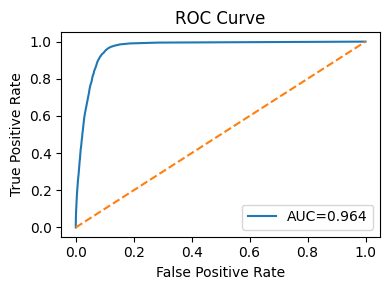

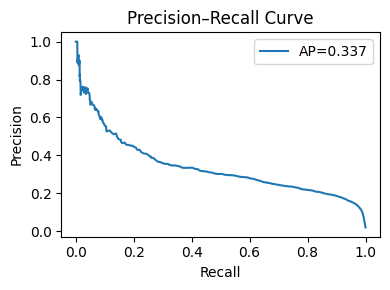

In [35]:
# Evaluation (Metrics + Curves)
roc = roc_auc_score(y_test, y_proba)
pr  = average_precision_score(y_test, y_proba)

print(f"ROC-AUC: {roc:.4f} | PR-AUC: {pr:.4f}\n")
print("== Classification Report (thr=0.50) ==")
print(classification_report(y_test, y_pred, digits=4))
print("== Confusion Matrix ==")
print(confusion_matrix(y_test, y_pred))

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(4,3))
plt.plot(fpr, tpr, label=f"AUC={roc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve"); plt.legend(); plt.tight_layout(); plt.show()

# Precision–Recall curve
prec, rec, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(4,3))
plt.plot(rec, prec, label=f"AP={pr:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall Curve"); plt.legend(); plt.tight_layout(); plt.show()


In [36]:
# Tiny Threshold Sweep (F2-tilted)
grid = [0.50, 0.30, 0.20, 0.15, 0.10]
rows = []
for thr in grid:
    pred_thr = (y_proba >= thr).astype(int)
    d = classification_report(y_test, pred_thr, output_dict=True, zero_division=0)
    p, r = d["1"]["precision"], d["1"]["recall"]
    beta = 2.0
    f2 = (1+beta**2)*p*r / (beta**2*p + r) if (p+r) > 0 else 0.0
    rows.append([thr, p, r, f2])

thr_df = pd.DataFrame(rows, columns=["threshold","precision_1","recall_1","f2_1"]) \
         .sort_values("f2_1", ascending=False) \
         .reset_index(drop=True)
thr_df


,threshold,precision_1,recall_1,f2_1
0,0.10,0.235939,0.736059,0.516917
1,0.15,0.284568,0.579926,0.480236
2,0.20,0.325875,0.422305,0.398708
3,0.30,0.444811,0.200743,0.225489
4,0.50,0.750000,0.040149,0.049523


In [37]:
# Finalize 
BEST_THR = float(thr_df.loc[0,"threshold"])
print(f"[INFO] Selected threshold by F2 → {BEST_THR}")

# Optional: save model pack (comment out if not needed)
# joblib.dump({"model": rf, "scaler": scaler, "feature_names": X.columns.tolist(), "threshold": BEST_THR},
#             BASE_DIR / "rf_model_notebook.joblib")

# One-row demo
sample = X.sample(1, random_state=42)
prob   = rf.predict_proba(sample)[:,1][0]
label  = int(prob >= BEST_THR)
print("\n=== Demo inference on one random sample ===")
display(sample.T)
print(f"Predicted probability: {prob:.3f} | Label@thr={BEST_THR}: {label}")


[INFO] Selected threshold by F2 → 0.1

=== Demo inference on one random sample ===


,60763
machineID,7
volt,162.2362
rotate,515.026931
pressure,87.245593
vibration,44.404307
volt_mean_3H,164.904899
volt_std_3H,8.042432
volt_mean_6H,174.138289
volt_std_6H,13.25254
rotate_mean_3H,421.346803


Predicted probability: 0.000 | Label@thr=0.1: 0
